# Implementation Questions

## Remark

- The dataset provided for the implementation part comes with train/test folders. You should keep the folders as is and use the given split. You can use the test folder for validation. You do not need to use a 70-10-20 split.
- For Q3 and Q4 of the implementation, you cannot change the structure of any of the Conv layers in ResNet18. You can only change the last FC layer to match the number of outputs needed.

## Question 1

#### Data Preprocessing

- Categorize the image base on the label in image name

Find train images: 18000
Find test images: 3600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of classes: 6
Feature batch shape: torch.Size([64, 1, 128, 128])
Labels batch shape: torch.Size([64])


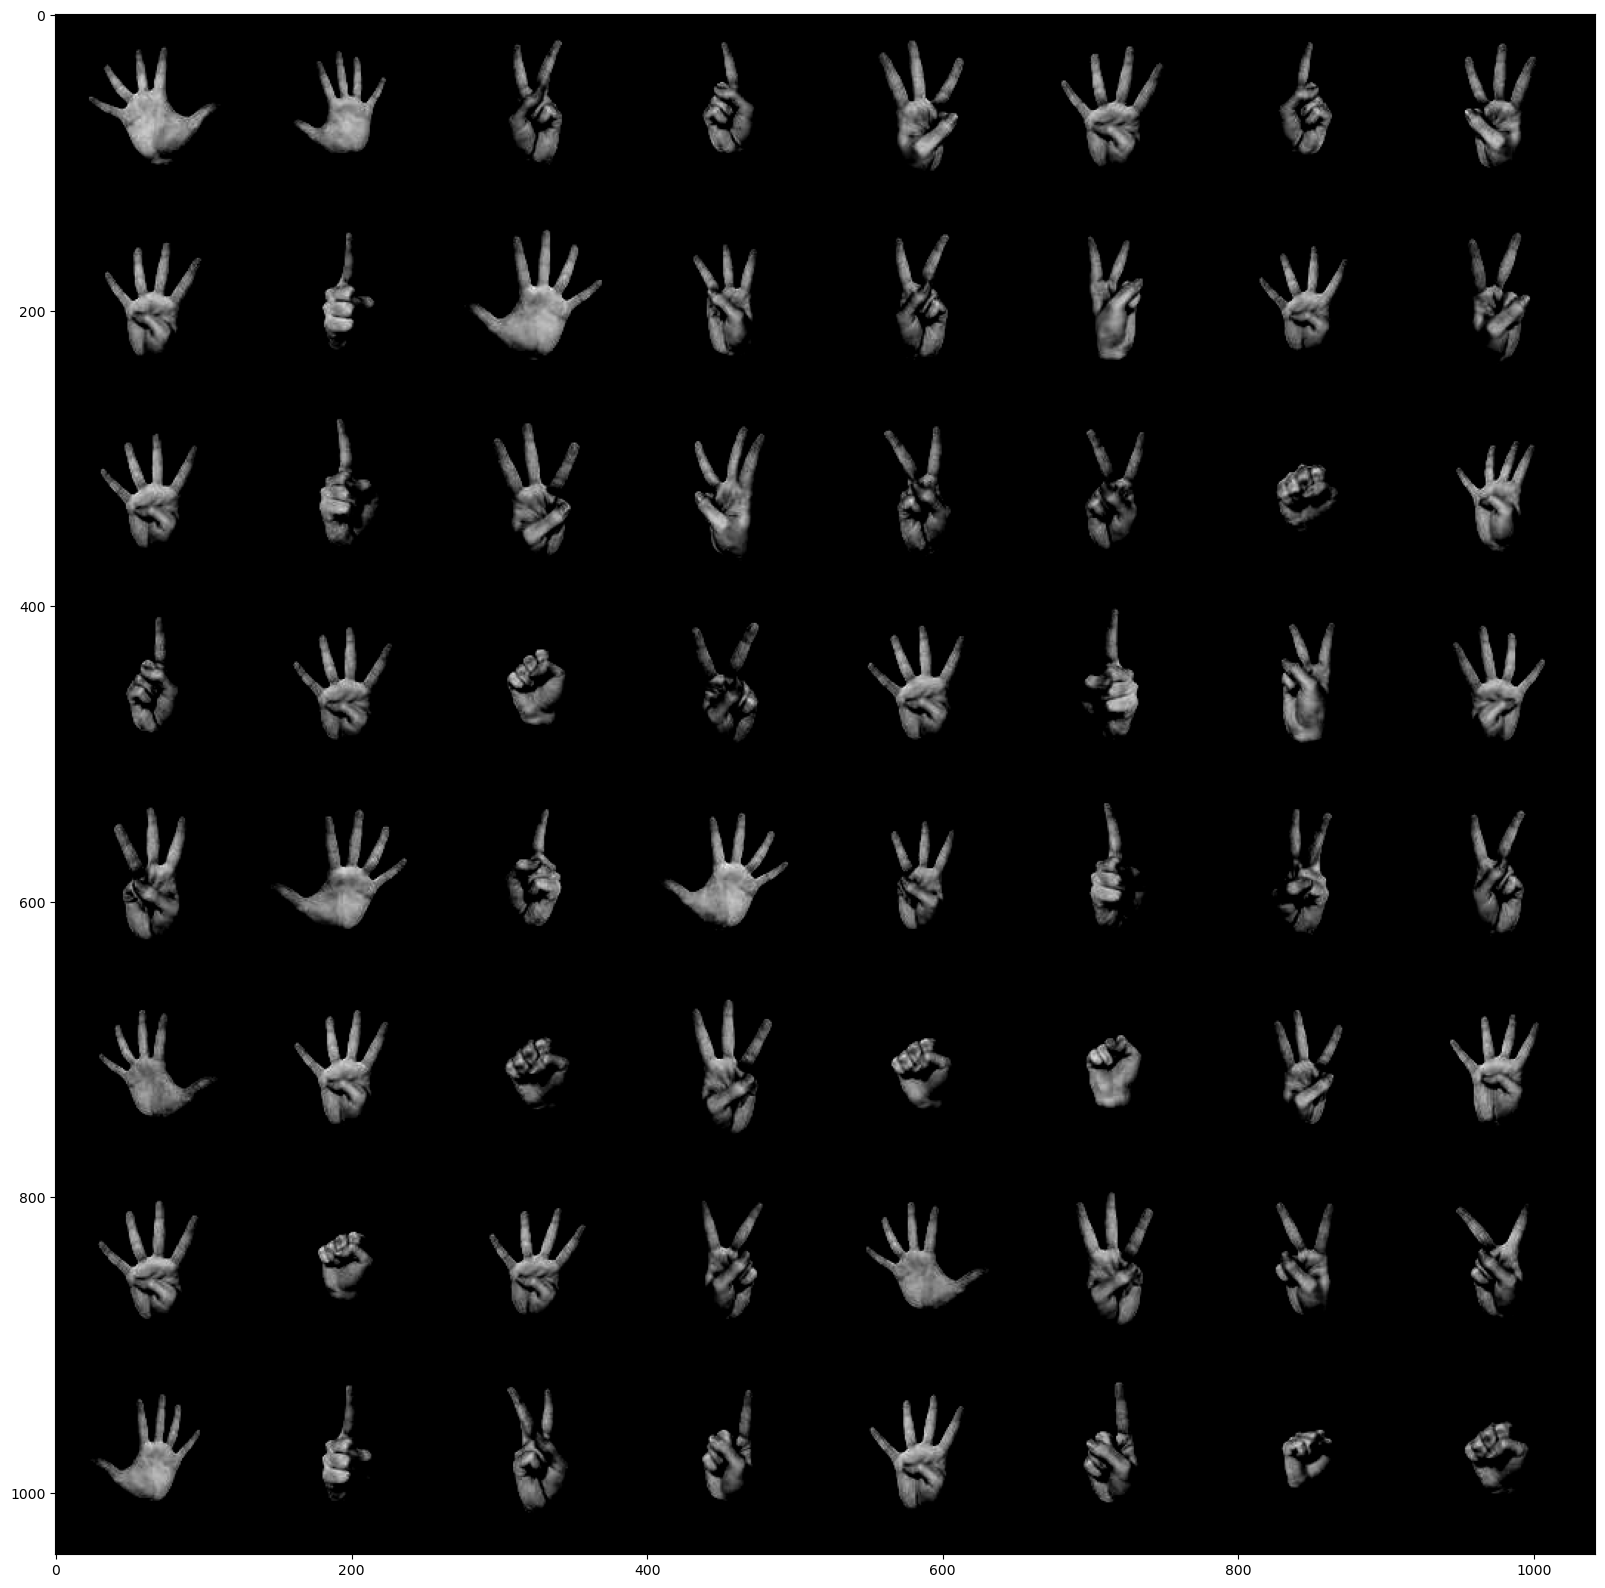

In [ ]:
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import glob
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


# ROOT_PATH = '/content/drive/MyDrive/comp6721-assignment/a3/'
ROOT_PATH = './a3'
training_path = f'{ROOT_PATH}/train/*.png'
test_path = f'{ROOT_PATH}/test/*.png'

# Model training constants
batch_size = 64
num_epochs = 15

# Loss function & optimizer constants
lr = 0.001
# step_size = 5
# gamma = 0.1

# Image constants
image_size = 128
mean = (0.5,)
std = (0.5,)

class CustomDataset(Dataset):
    def __init__(self, image_list, transforms=None):
        self.image_list=image_list
        self.transforms=transforms
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        single_image_path = self.image_list[index]
        im_as_im = Image.open(single_image_path)
        if self.transforms:
            im_as_im=self.transforms(im_as_im)
        class_indicator_location = single_image_path.rfind('_')
        # extract the number from image name
        label = int(single_image_path[class_indicator_location+1:class_indicator_location+2])
        return (im_as_im, label)


data_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_img_list = glob.glob(training_path)
test_img_list = glob.glob(test_path)
print(f"Find train images: {len(train_img_list)}")
print(f"Find test images: {len(test_img_list)}", )

train_set = CustomDataset(train_img_list, transforms = data_transform)
test_set = CustomDataset(test_img_list, transforms = data_transform)
train_labels = [train_set[i][1] for i in range(len(train_set))]
num_classes = len(set(train_labels))
print(f"Number of classes: {num_classes}")

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

# Image samples
images, targets = next(iter(train_dataloader))
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {targets.size()}")

# Reshape images to have shape [B, 1, H, W]
# images = images.reshape(-1, 1, image_size, image_size)
grid_images = torchvision.utils.make_grid(images, nrow=8)
np_image = np.array(grid_images).transpose((1,2,0))
# unnorm_image = np_image * std + mean
plt.figure(figsize=(20,20))
plt.imshow(np_image)
        

#### Define the CNN Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64 * 32 * 32, out_features=1024)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=1024, out_features=20)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # print(x.shape)
        x = x.view(-1, 64 * 32 * 32)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

#### Training

- Train the model
- Plot training and validation accuracy vs batch/epoch

Model Architecture
: SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=1024, out_features=20, bias=True)
)
Epoch [ 1/15], Step [ 50/  4], Loss: 0.0405, Accuracy: 0.9844
Epoch [ 1/15], Step [100/  4], Loss: 0.0062, Accuracy: 1.0000
Epoch [ 1/15], Step [150/  4], Loss: 0.0068, Accuracy: 1.0000
Epoch [ 1/15], Step [200/  4], Loss: 0.0008, Accuracy: 1.0000
Epoch [ 1/15], Step [250/  4], Loss: 0.0002, Accuracy: 1.0000
Epoch [ 1/15], Validation Accuracy: 0.9997
Epoch [ 2/15], Step [ 50/  4], Loss: 0.0001, Accuracy: 1.0000
Epoch [ 2/15], Step [100/  4], Loss: 0.0076, 

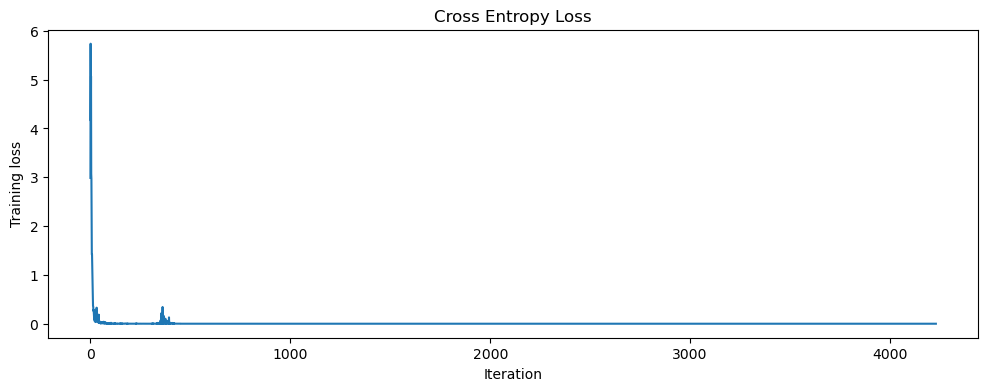

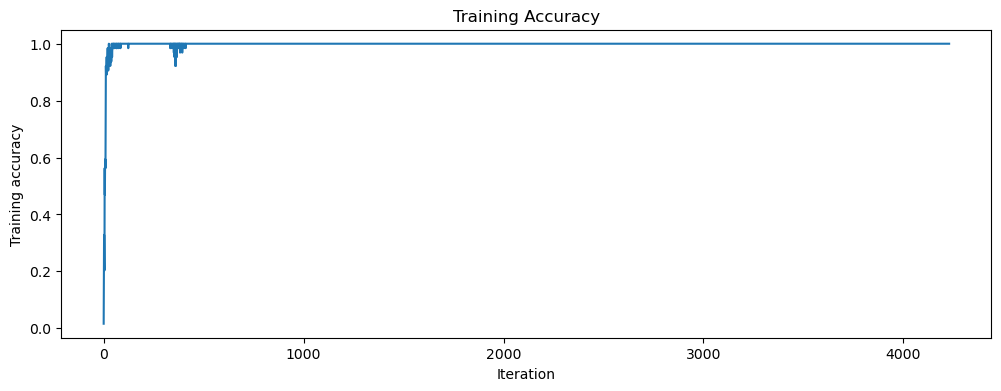

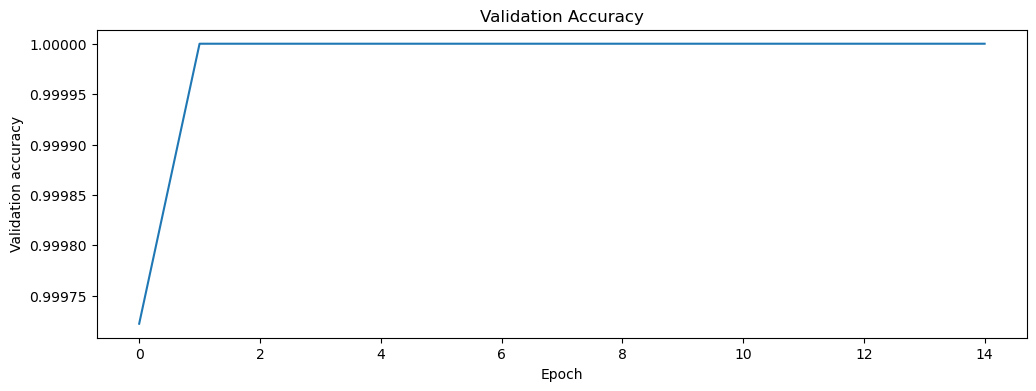

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
print(f"Model Architecture\n: {model}")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training
losses = []
train_accuracy = []
validation_accuracy = []

for epoch in range(num_epochs):
    for i , (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        #train model
        outputs = model(inputs)
        
        #criterion
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #update parameters
        optimizer.step()
        
        #accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()
        train_accuracy.append(correct / total)

        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f, Accuracy: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataloader) // batch_size, loss.item(), correct / total))
            
     # Evaluate on the validation dataset
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, targets in test_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total = targets.size(0)
            total_samples += total
            total_correct += (predicted == targets).sum().item()

        valid_acc = total_correct / total_samples
        validation_accuracy.append(valid_acc)
        print('Epoch [%2d/%2d], Validation Accuracy: %.4f' % (epoch + 1, num_epochs, valid_acc))


plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.title('Cross Entropy Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(train_accuracy)
plt.xlabel('Iteration')
plt.ylabel('Training accuracy')
plt.title('Training Accuracy')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation Accuracy')
plt.show()

#### Valuation

Show classification scores (accuracy, recal, confusion matrix)

In [ ]:
# Valuation
def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, test_dataloader, device)

Train accuracy: 100.00
Test accuracy: 100.00
Confusion Matrix:
[[600   0   0   0   0   0]
 [  0 600   0   0   0   0]
 [  0   0 600   0   0   0]
 [  0   0   0 600   0   0]
 [  0   0   0   0 600   0]
 [  0   0   0   0   0 600]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       600
           2       1.00      1.00      1.00       600
           3       1.00      1.00      1.00       600
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



## Question 2

#### Data Preprocessing

- Categorize the image base on the label in image name

Find train images: 18000
Find test images: 3600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of classes: 12
Class: ['0-left', '2-left', '5-left', '5-right', '2-right', '3-left', '0-right', '4-left', '1-left', '3-right', '4-right', '1-right']
Feature batch shape: torch.Size([64, 1, 128, 128])
Labels batch shape: torch.Size([64])


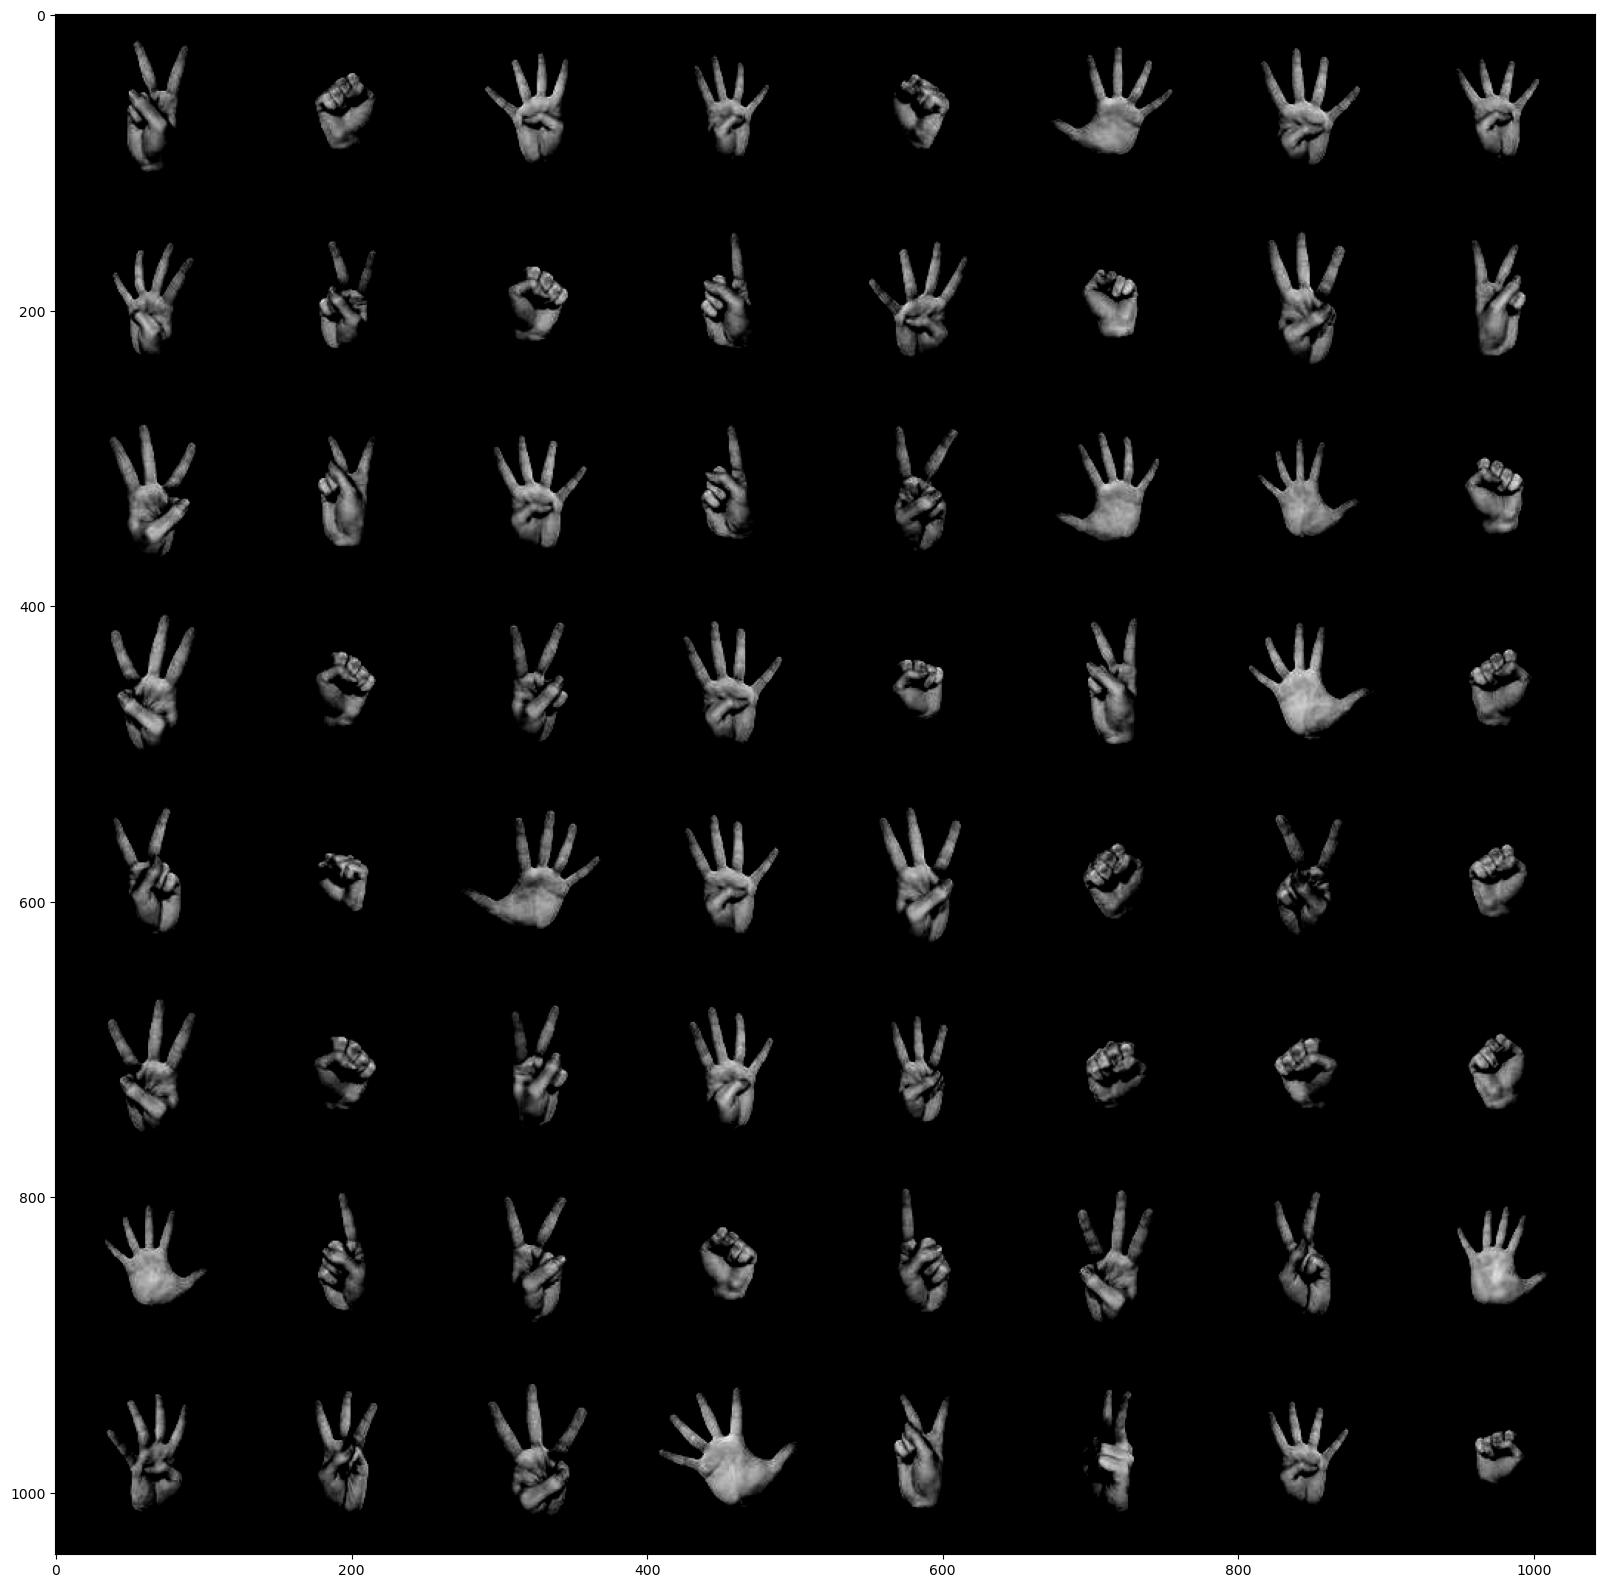

In [ ]:
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import glob
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


# ROOT_PATH = '/content/drive/MyDrive/comp6721-assignment/a3/'
ROOT_PATH = './a3'
training_path = f'{ROOT_PATH}/train/*.png'
test_path = f'{ROOT_PATH}/test/*.png'

# Model training constants
batch_size = 64
num_epochs = 15

# Loss function & optimizer constants
lr = 0.001
# step_size = 5
# gamma = 0.1

# Image constants
image_size = 128
mean = (0.5,)
std = (0.5,)

# Global variable
label_list = []

def extract_label(single_image_path):
    class_indicator_location = single_image_path.rfind('_')
    label = single_image_path[class_indicator_location+1:class_indicator_location+2]
    hand = single_image_path[class_indicator_location+2:class_indicator_location+3]
    if hand.lower() == "l":
        label += "-left"
    else:
        label += "-right"

    if label in label_list:
        return label_list.index(label)
    
    label_list.append(label)
    return label_list.index(label)


class CustomDataset(Dataset):
    def __init__(self, image_list, transforms=None):
        self.image_list=image_list
        self.transforms=transforms
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        single_image_path = self.image_list[index]
        im_as_im = Image.open(single_image_path)
        if self.transforms:
            im_as_im=self.transforms(im_as_im)
        # extract the class from image path
        label = extract_label(single_image_path)
        return (im_as_im, label)


data_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_img_list = glob.glob(training_path)
test_img_list = glob.glob(test_path)
print(f"Find train images: {len(train_img_list)}")
print(f"Find test images: {len(test_img_list)}", )

train_set = CustomDataset(train_img_list, transforms = data_transform)
test_set = CustomDataset(test_img_list, transforms = data_transform)
train_labels = [train_set[i][1] for i in range(len(train_set))]
num_classes = len(set(train_labels))
print(f"Number of classes: {num_classes}")
print(f"Class: {label_list}")

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

# Image samples
images, targets = next(iter(train_dataloader))
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {targets.size()}")

# Reshape images to have shape [B, 1, H, W]
grid_images = torchvision.utils.make_grid(images, nrow=8)
np_image = np.array(grid_images).transpose((1,2,0))
plt.figure(figsize=(20,20))
plt.imshow(np_image)
        

#### Define the CNN Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64 * 32 * 32, out_features=1024)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=1024, out_features=20)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # print(x.shape)
        x = x.view(-1, 64 * 32 * 32)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

#### Training

- Train the model
- Plot training and validation accuracy vs batch/epoch

Model Architecture
: SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=1024, out_features=20, bias=True)
)
Epoch [ 1/15], Step [ 50/  4], Loss: 0.1168, Accuracy: 0.9844
Epoch [ 1/15], Step [100/  4], Loss: 0.0049, Accuracy: 1.0000
Epoch [ 1/15], Step [150/  4], Loss: 0.0031, Accuracy: 1.0000
Epoch [ 1/15], Step [200/  4], Loss: 0.0005, Accuracy: 1.0000
Epoch [ 1/15], Step [250/  4], Loss: 0.0017, Accuracy: 1.0000
Epoch [ 1/15], Validation Accuracy: 1.0000
Epoch [ 2/15], Step [ 50/  4], Loss: 0.0012, Accuracy: 1.0000
Epoch [ 2/15], Step [100/  4], Loss: 0.0001, 

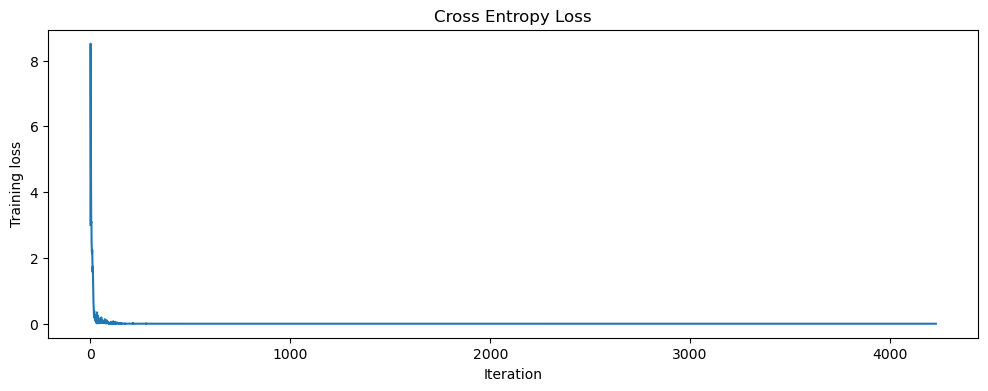

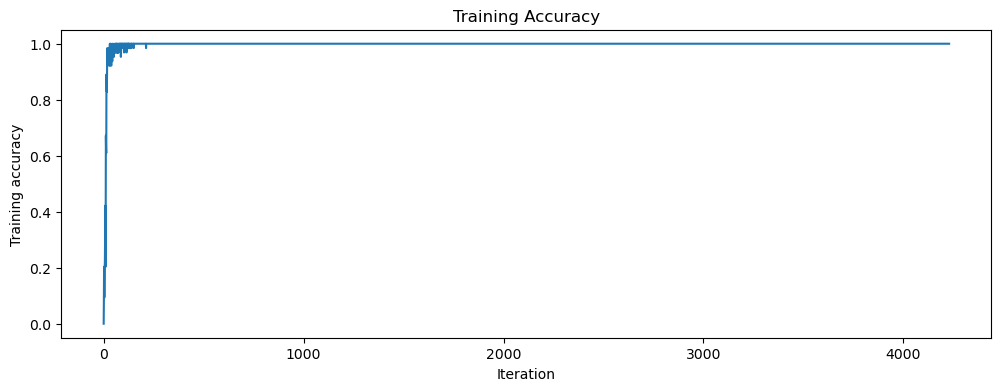

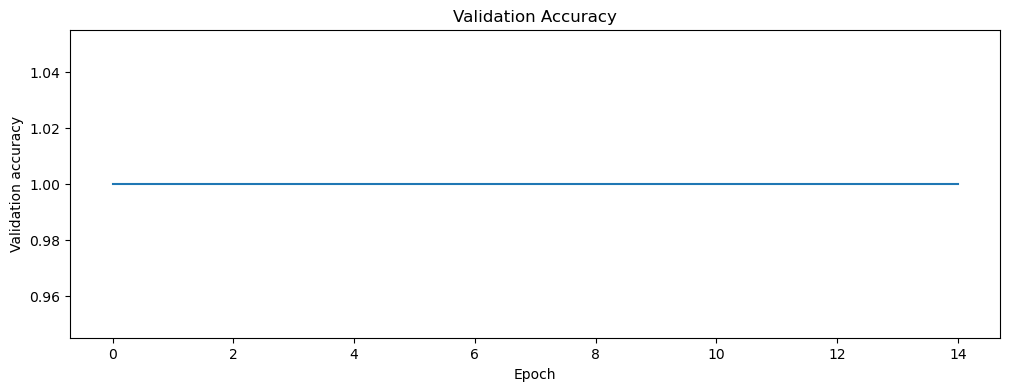

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
print(f"Model Architecture\n: {model}")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training
losses = []
train_accuracy = []
validation_accuracy = []

for epoch in range(num_epochs):
    for i , (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        #train model
        outputs = model(inputs)
        
        #criterion
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #update parameters
        optimizer.step()
        
        #accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()
        train_accuracy.append(correct / total)

        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f, Accuracy: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataloader) // batch_size, loss.item(), correct / total))
            
     # Evaluate on the validation dataset
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, targets in test_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total = targets.size(0)
            total_samples += total
            total_correct += (predicted == targets).sum().item()

        valid_acc = total_correct / total_samples
        validation_accuracy.append(valid_acc)
        print('Epoch [%2d/%2d], Validation Accuracy: %.4f' % (epoch + 1, num_epochs, valid_acc))


plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.title('Cross Entropy Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(train_accuracy)
plt.xlabel('Iteration')
plt.ylabel('Training accuracy')
plt.title('Training Accuracy')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation Accuracy')
plt.show()

#### Valuation

Show classification scores (accuracy, recal, confusion matrix)

Train accuracy: 100.00
Test accuracy: 100.00
Confusion Matrix:
[[300   0   0   0   0   0   0   0   0   0   0   0]
 [  0 300   0   0   0   0   0   0   0   0   0   0]
 [  0   0 300   0   0   0   0   0   0   0   0   0]
 [  0   0   0 300   0   0   0   0   0   0   0   0]
 [  0   0   0   0 300   0   0   0   0   0   0   0]
 [  0   0   0   0   0 300   0   0   0   0   0   0]
 [  0   0   0   0   0   0 300   0   0   0   0   0]
 [  0   0   0   0   0   0   0 300   0   0   0   0]
 [  0   0   0   0   0   0   0   0 300   0   0   0]
 [  0   0   0   0   0   0   0   0   0 300   0   0]
 [  0   0   0   0   0   0   0   0   0   0 300   0]
 [  0   0   0   0   0   0   0   0   0   0   0 300]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300
           4       1.00      1

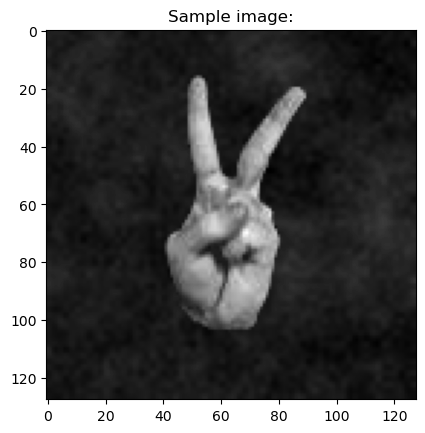

Predicted: 2-left, Actual: 2-left


In [ ]:
def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, test_dataloader, device)

# Sample one from test dataset
# get a random batch from the test dataloader
images, targets = next(iter(test_dataloader))

# pick a random image from the batch
idx = np.random.randint(batch_size)
image, target = images[idx], targets[idx]

sample_image = np.transpose(image, (1, 2, 0))
plt.imshow(sample_image, cmap='gray')
plt.title(f"Sample image:")
plt.show()

image = image.to(device)
target = target.to(device)

# send the image through the model to get predictions
with torch.no_grad():
    output = model(image.unsqueeze(0))
    pred = torch.argmax(output, dim=1).item()

# compare the predicted label with the actual label
actual = target.item()
print(f"Predicted: {label_list[pred]}, Actual: {label_list[actual]}")



## Question 3

#### Data Preprocessing

- Categorize the image base on the label in image name

Find train images: 18000
Find test images: 3600


Number of classes: 12
Class: ['2-left', '3-left', '5-left', '4-right', '0-left', '5-right', '0-right', '2-right', '1-right', '3-right', '4-left', '1-left']
Feature batch shape: torch.Size([64, 1, 128, 128])
Labels batch shape: torch.Size([64])


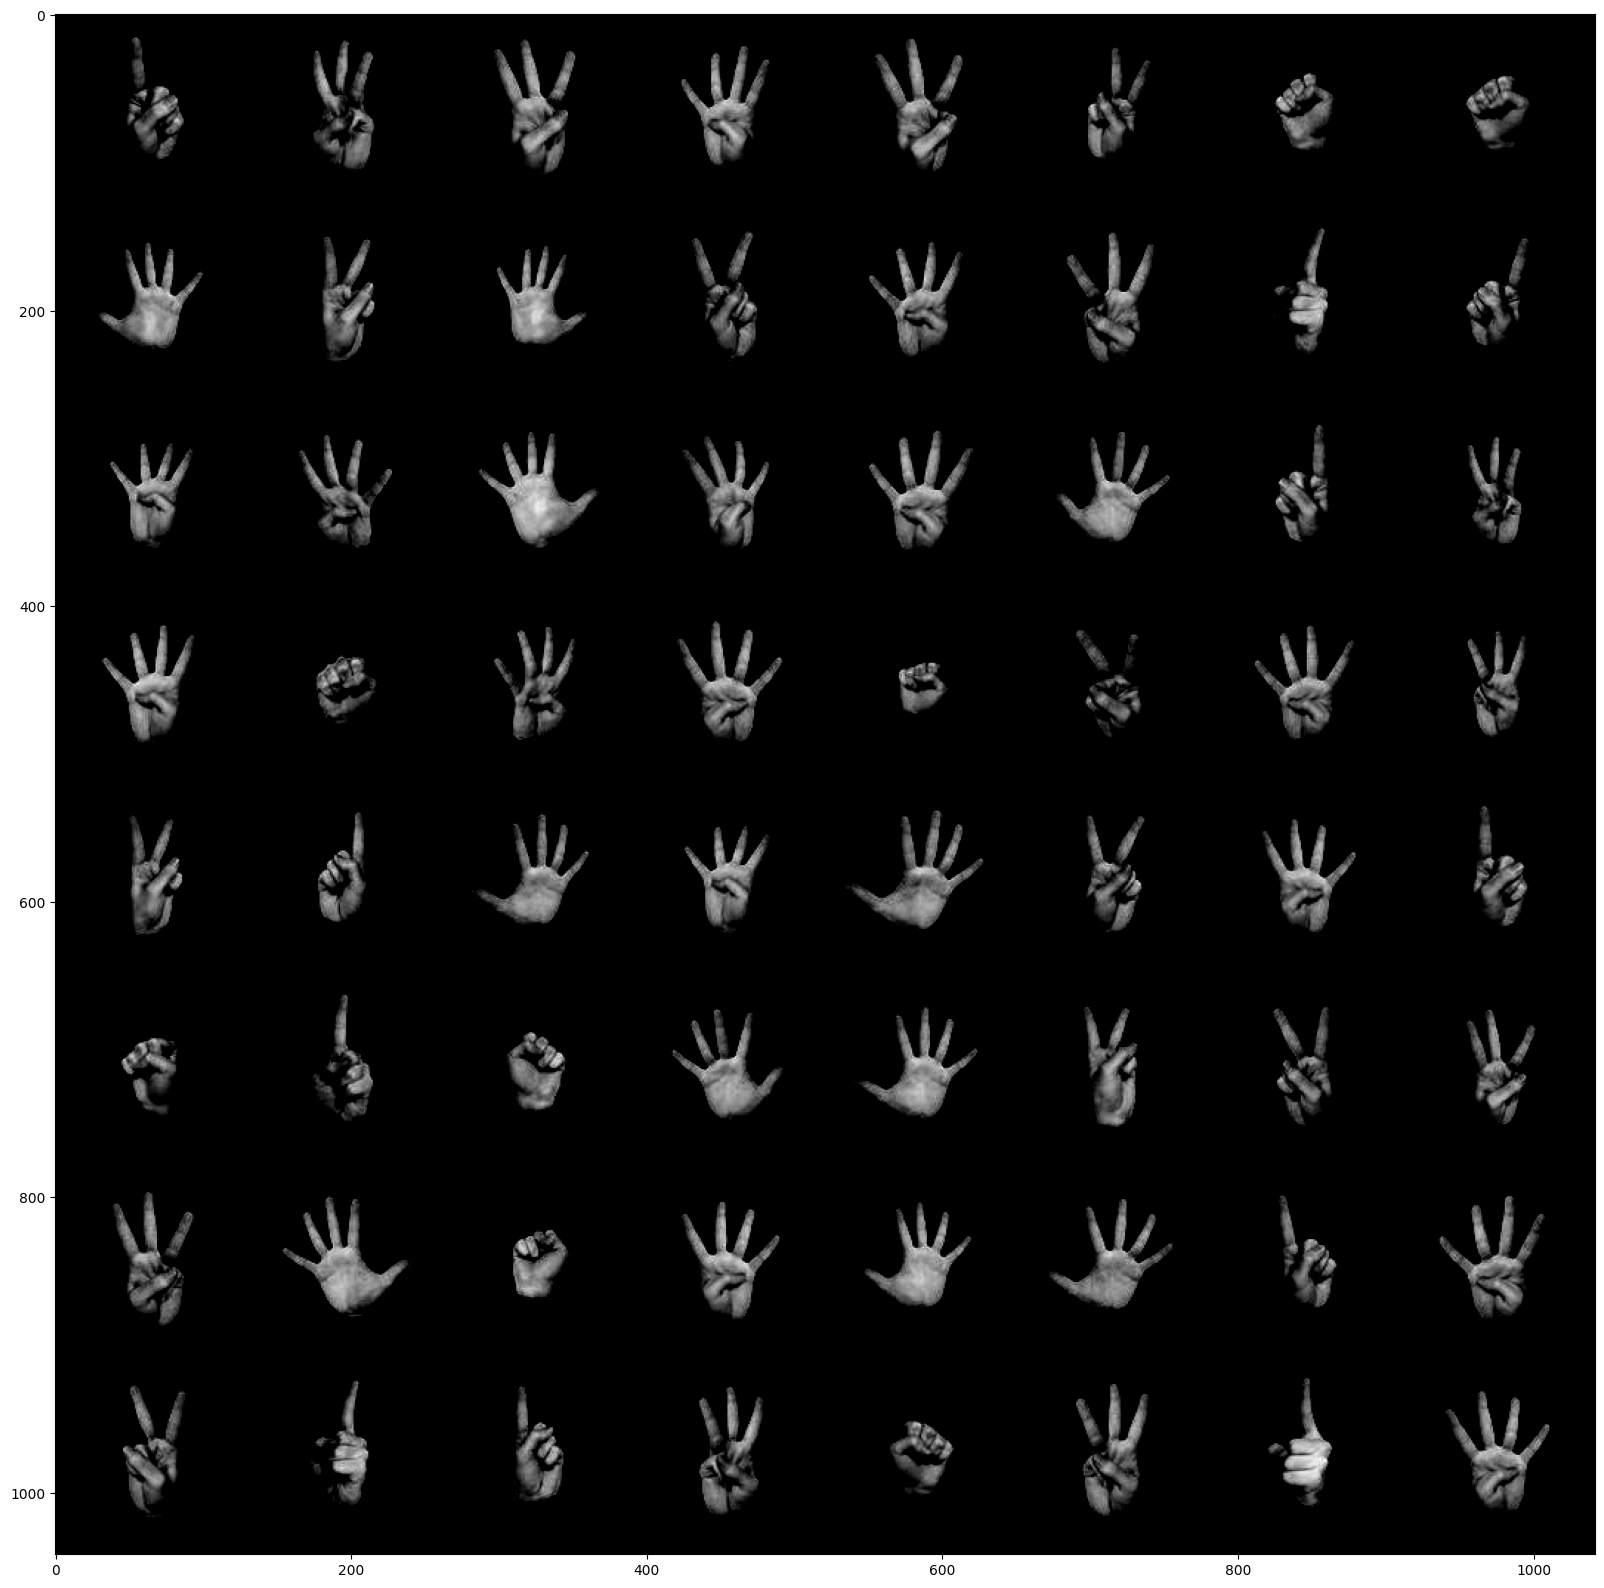

In [ ]:
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import glob
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


ROOT_PATH = '/content/drive/MyDrive/comp6721-assignment/a3/'
training_path = f'{ROOT_PATH}/train/*.png'
test_path = f'{ROOT_PATH}/test/*.png'

# Model training constants
batch_size = 64
num_epochs = 15

# Loss function & optimizer constants
lr = 0.001
# step_size = 5
# gamma = 0.1

# Image constants
image_size = 128
mean = (0.5,)
std = (0.5,)

# Global variable
label_list = []

def extract_label(single_image_path):
    class_indicator_location = single_image_path.rfind('_')
    label = single_image_path[class_indicator_location+1:class_indicator_location+2]
    hand = single_image_path[class_indicator_location+2:class_indicator_location+3]
    if hand.lower() == "l":
        label += "-left"
    else:
        label += "-right"

    if label in label_list:
        return label_list.index(label)
    
    label_list.append(label)
    return label_list.index(label)


class CustomDataset(Dataset):
    def __init__(self, image_list, transforms=None):
        self.image_list=image_list
        self.transforms=transforms
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        single_image_path = self.image_list[index]
        im_as_im = Image.open(single_image_path)
        if self.transforms:
            im_as_im=self.transforms(im_as_im)
        # extract the class from image path
        label = extract_label(single_image_path)
        return (im_as_im, label)


data_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_img_list = glob.glob(training_path)
test_img_list = glob.glob(test_path)
print(f"Find train images: {len(train_img_list)}")
print(f"Find test images: {len(test_img_list)}", )

train_set = CustomDataset(train_img_list, transforms = data_transform)
test_set = CustomDataset(test_img_list, transforms = data_transform)
train_labels = [train_set[i][1] for i in range(len(train_set))]
num_classes = len(set(train_labels))
print(f"Number of classes: {num_classes}")
print(f"Class: {label_list}")

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

# Image samples
images, targets = next(iter(train_dataloader))
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {targets.size()}")

# Reshape images to have shape [B, 1, H, W]
grid_images = torchvision.utils.make_grid(images, nrow=8)
np_image = np.array(grid_images).transpose((1,2,0))
plt.figure(figsize=(20,20))
plt.imshow(np_image)
        

#### Define the CNN Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models


class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=False)
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet18(x)
        return x

#### Training

- Train the model
- Plot training and validation accuracy vs batch/epoch

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model Architecture
: ResNet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

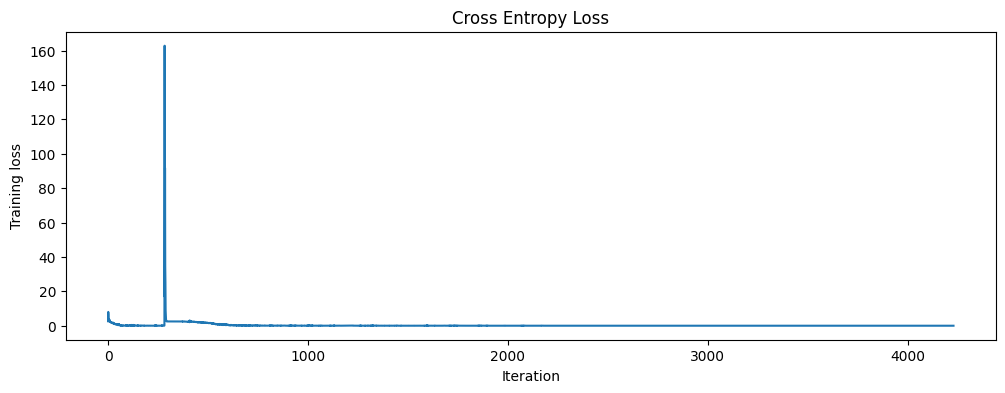

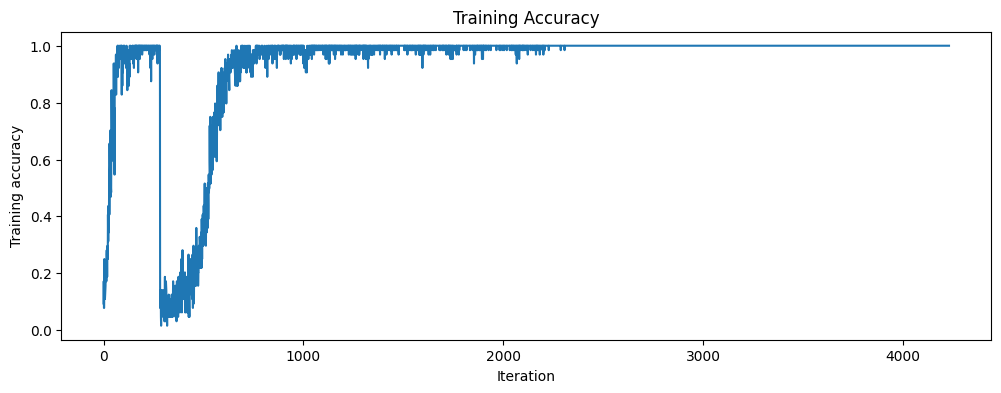

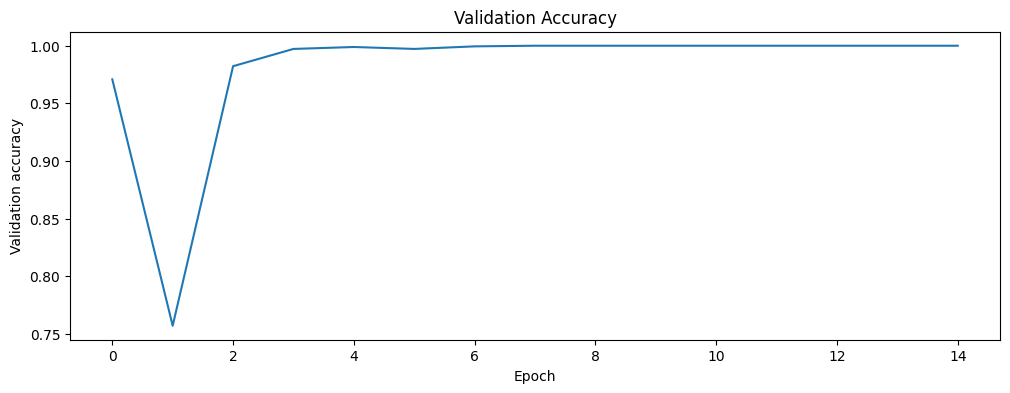

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=num_classes).to(device)
print(f"Model Architecture\n: {model}")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training
losses = []
train_accuracy = []
validation_accuracy = []

for epoch in range(num_epochs):
    for i , (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        inputs = torch.cat((inputs, inputs, inputs), dim=1)  # convert grayscale to RGB

        #train model
        outputs = model(inputs)
        
        #criterion
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #update parameters
        optimizer.step()
        
        #accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()
        train_accuracy.append(correct / total)

        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f, Accuracy: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataloader) // batch_size, loss.item(), correct / total))
            
     # Evaluate on the validation dataset
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, targets in test_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            inputs = torch.cat((inputs, inputs, inputs), dim=1)  # convert grayscale to RGB

            # Forward pass
            outputs = model(inputs)

            # Compute the validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total = targets.size(0)
            total_samples += total
            total_correct += (predicted == targets).sum().item()

        valid_acc = total_correct / total_samples
        validation_accuracy.append(valid_acc)
        print('Epoch [%2d/%2d], Validation Accuracy: %.4f' % (epoch + 1, num_epochs, valid_acc))


plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.title('Cross Entropy Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(train_accuracy)
plt.xlabel('Iteration')
plt.ylabel('Training accuracy')
plt.title('Training Accuracy')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation Accuracy')
plt.show()

#### Valuation

Show classification scores (accuracy, recal, confusion matrix)

Train accuracy: 100.00
Test accuracy: 100.00
Confusion Matrix:
[[300   0   0   0   0   0   0   0   0   0   0   0]
 [  0 300   0   0   0   0   0   0   0   0   0   0]
 [  0   0 300   0   0   0   0   0   0   0   0   0]
 [  0   0   0 300   0   0   0   0   0   0   0   0]
 [  0   0   0   0 300   0   0   0   0   0   0   0]
 [  0   0   0   0   0 300   0   0   0   0   0   0]
 [  0   0   0   0   0   0 300   0   0   0   0   0]
 [  0   0   0   0   0   0   0 300   0   0   0   0]
 [  0   0   0   0   0   0   0   0 300   0   0   0]
 [  0   0   0   0   0   0   0   0   0 300   0   0]
 [  0   0   0   0   0   0   0   0   0   0 300   0]
 [  0   0   0   0   0   0   0   0   0   0   0 300]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300
           4       1.00      1

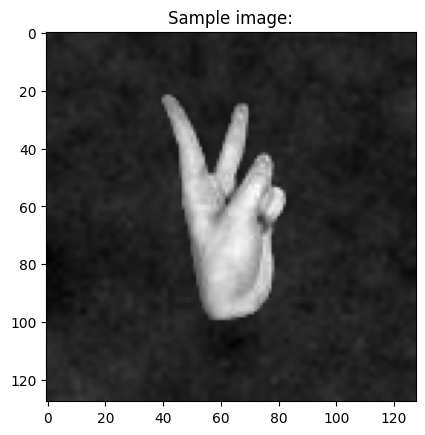

Predicted: 2-left, Actual: 2-left


In [ ]:
def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = torch.cat((inputs, inputs, inputs), dim=1)  # convert grayscale to RGB


            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, test_dataloader, device)

# Sample one from test dataset
# get a random batch from the test dataloader
images, targets = next(iter(test_dataloader))

# pick a random image from the batch
idx = np.random.randint(batch_size)
image, target = images[idx], targets[idx]

sample_image = np.transpose(image, (1, 2, 0))
plt.imshow(sample_image, cmap='gray')
plt.title(f"Sample image:")
plt.show()

image = image.to(device)
target = target.to(device)
# convert grayscale to RGB by repeating the channel
image = image.repeat(1, 3, 1, 1)


# send the image through the model to get predictions
with torch.no_grad():
    output = model(image)
    pred = torch.argmax(output, dim=1).item()

# compare the predicted label with the actual label
actual = target.item()
print(f"Predicted: {label_list[pred]}, Actual: {label_list[actual]}")



## Question 4

#### Data Preprocessing

- Categorize the image base on the label in image name

Find train images: 18000
Find test images: 3600


Number of classes: 12
Class: ['2-left', '3-left', '5-left', '4-right', '0-left', '5-right', '0-right', '2-right', '1-right', '3-right', '4-left', '1-left']
Feature batch shape: torch.Size([64, 1, 128, 128])
Labels batch shape: torch.Size([64])


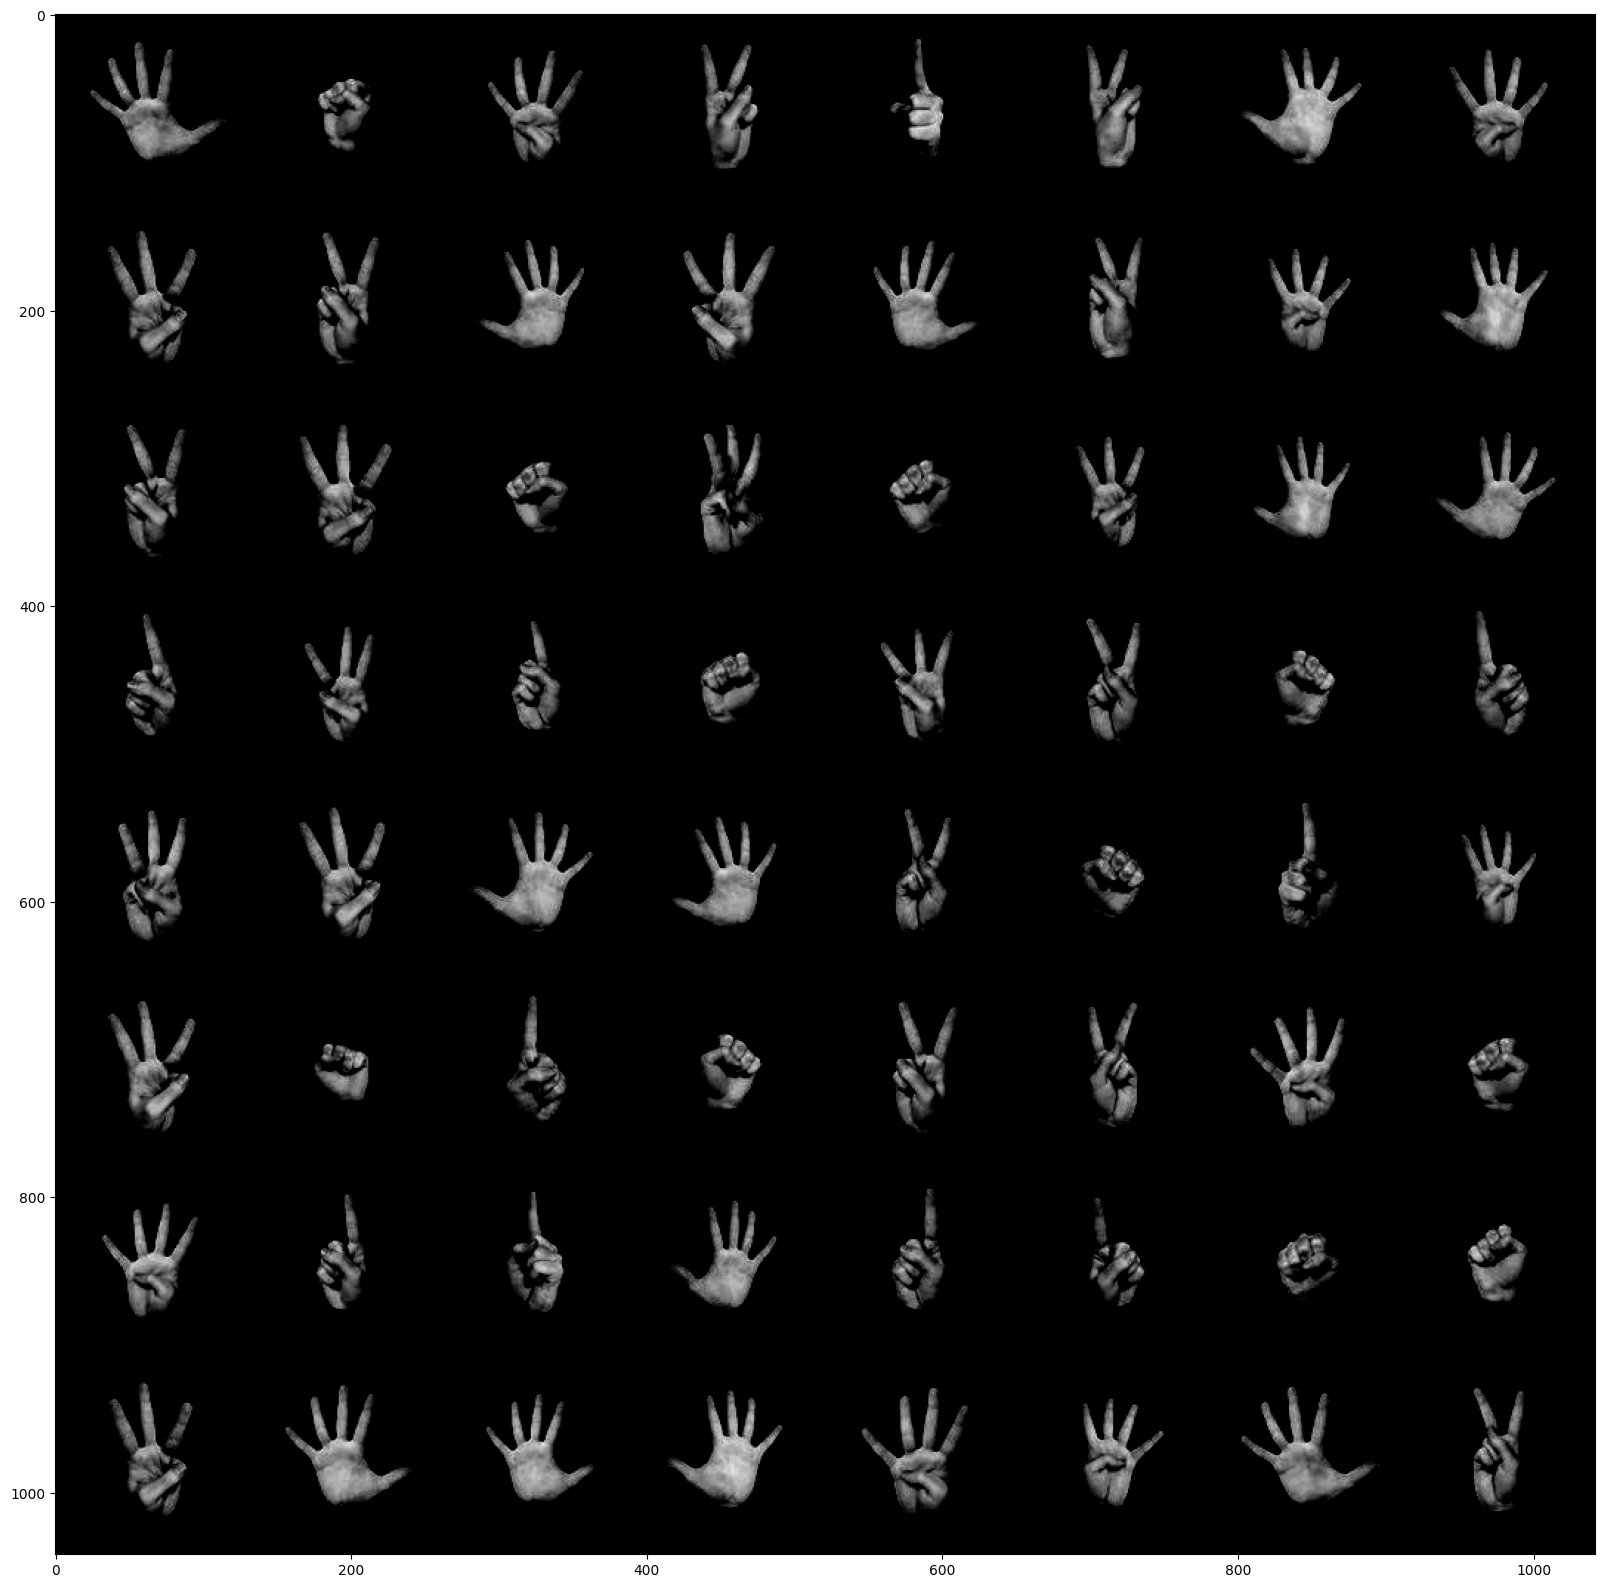

In [ ]:
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import glob
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


ROOT_PATH = '/content/drive/MyDrive/comp6721-assignment/a3/'
training_path = f'{ROOT_PATH}/train/*.png'
test_path = f'{ROOT_PATH}/test/*.png'

# Model training constants
batch_size = 64
num_epochs = 15

# Loss function & optimizer constants
lr = 0.001
# step_size = 5
# gamma = 0.1

# Image constants
image_size = 128
mean = (0.5,)
std = (0.5,)

# Global variable
label_list = []

def extract_label(single_image_path):
    class_indicator_location = single_image_path.rfind('_')
    label = single_image_path[class_indicator_location+1:class_indicator_location+2]
    hand = single_image_path[class_indicator_location+2:class_indicator_location+3]
    if hand.lower() == "l":
        label += "-left"
    else:
        label += "-right"

    if label in label_list:
        return label_list.index(label)
    
    label_list.append(label)
    return label_list.index(label)


class CustomDataset(Dataset):
    def __init__(self, image_list, transforms=None):
        self.image_list=image_list
        self.transforms=transforms
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        single_image_path = self.image_list[index]
        im_as_im = Image.open(single_image_path)
        if self.transforms:
            im_as_im=self.transforms(im_as_im)
        # extract the class from image path
        label = extract_label(single_image_path)
        return (im_as_im, label)


data_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_img_list = glob.glob(training_path)
test_img_list = glob.glob(test_path)
print(f"Find train images: {len(train_img_list)}")
print(f"Find test images: {len(test_img_list)}", )

train_set = CustomDataset(train_img_list, transforms = data_transform)
test_set = CustomDataset(test_img_list, transforms = data_transform)
train_labels = [train_set[i][1] for i in range(len(train_set))]
num_classes = len(set(train_labels))
print(f"Number of classes: {num_classes}")
print(f"Class: {label_list}")

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

# Image samples
images, targets = next(iter(train_dataloader))
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {targets.size()}")

# Reshape images to have shape [B, 1, H, W]
grid_images = torchvision.utils.make_grid(images, nrow=8)
np_image = np.array(grid_images).transpose((1,2,0))
plt.figure(figsize=(20,20))
plt.imshow(np_image)
        

#### Define the CNN Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models


class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        
        # Load pre-trained ResNet18 model from PyTorch
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Freeze all layers except for the final fully connected layer
        for param in self.resnet18.parameters():
            param.requires_grad = False

        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet18(x)
        return x

#### Training

- Train the model
- Plot training and validation accuracy vs batch/epoch

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Model Architecture
: ResNet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

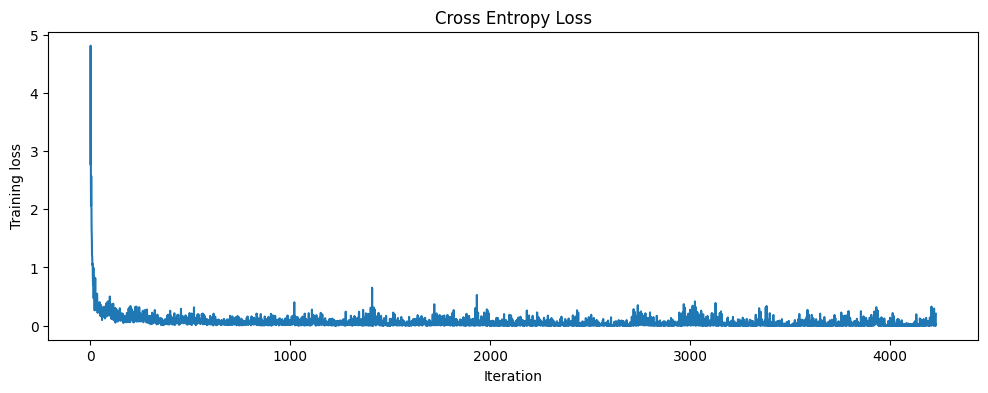

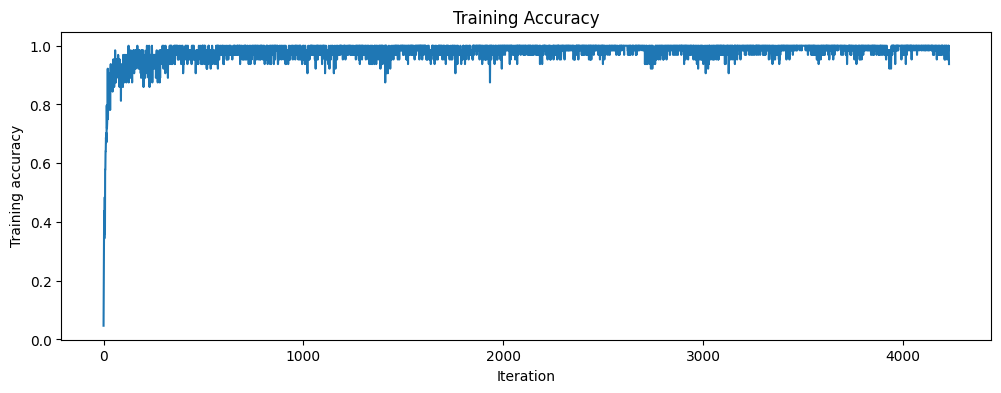

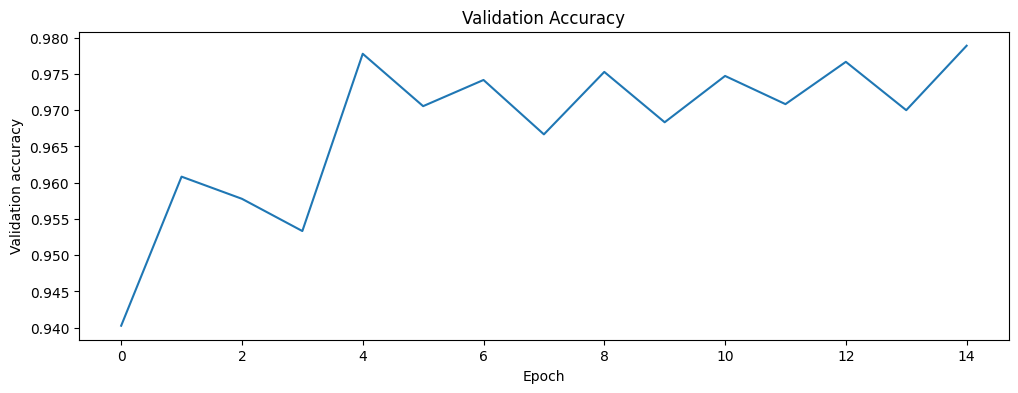

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=num_classes).to(device)
print(f"Model Architecture\n: {model}")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training
losses = []
train_accuracy = []
validation_accuracy = []

for epoch in range(num_epochs):
    for i , (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        inputs = torch.cat((inputs, inputs, inputs), dim=1)  # convert grayscale to RGB

        #train model
        outputs = model(inputs)
        
        #criterion
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #update parameters
        optimizer.step()
        
        #accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()
        train_accuracy.append(correct / total)

        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f, Accuracy: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataloader) // batch_size, loss.item(), correct / total))
            
     # Evaluate on the validation dataset
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, targets in test_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            inputs = torch.cat((inputs, inputs, inputs), dim=1)  # convert grayscale to RGB

            # Forward pass
            outputs = model(inputs)

            # Compute the validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total = targets.size(0)
            total_samples += total
            total_correct += (predicted == targets).sum().item()

        valid_acc = total_correct / total_samples
        validation_accuracy.append(valid_acc)
        print('Epoch [%2d/%2d], Validation Accuracy: %.4f' % (epoch + 1, num_epochs, valid_acc))


plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.title('Cross Entropy Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(train_accuracy)
plt.xlabel('Iteration')
plt.ylabel('Training accuracy')
plt.title('Training Accuracy')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation Accuracy')
plt.show()


#### Valuation

Show classification scores (accuracy, recal, confusion matrix)

Train accuracy: 99.61
Test accuracy: 97.89
Confusion Matrix:
[[290   0   0   0   0   0   0   4   0   0   0   6]
 [  2 293   0   0   0   0   0   0   0   4   1   0]
 [  0   0 299   0   0   0   0   0   0   0   1   0]
 [  0   0   0 296   0   0   0   0   0   0   4   0]
 [  0   0   0   0 298   0   2   0   0   0   0   0]
 [  0   0   0   0   0 300   0   0   0   0   0   0]
 [  0   0   0   0  10   0 289   0   0   0   0   1]
 [ 10   0   0   0   0   0   0 285   2   2   0   1]
 [  0   0   0   0   0   0   1   0 295   0   0   4]
 [  1   6   0   2   0   0   0   7   0 282   2   0]
 [  0   0   0   0   0   0   0   0   0   0 300   0]
 [  0   0   0   0   0   0   0   0   3   0   0 297]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       300
           1       0.98      0.98      0.98       300
           2       1.00      1.00      1.00       300
           3       0.99      0.99      0.99       300
           4       0.97      0.9

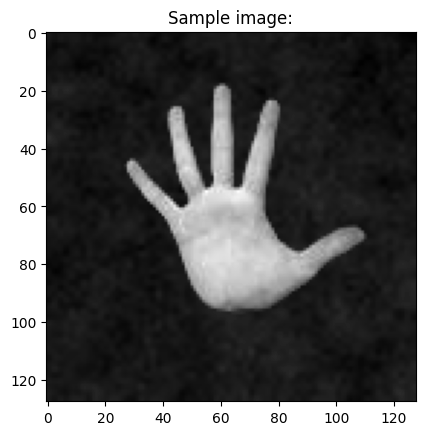

Predicted: 5-right, Actual: 5-right


In [ ]:
def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = torch.cat((inputs, inputs, inputs), dim=1)  # convert grayscale to RGB


            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, test_dataloader, device)

# Sample one from test dataset
# get a random batch from the test dataloader
images, targets = next(iter(test_dataloader))

# pick a random image from the batch
idx = np.random.randint(batch_size)
image, target = images[idx], targets[idx]

sample_image = np.transpose(image, (1, 2, 0))
plt.imshow(sample_image, cmap='gray')
plt.title(f"Sample image:")
plt.show()

image = image.to(device)
target = target.to(device)
# convert grayscale to RGB by repeating the channel
image = image.repeat(1, 3, 1, 1)


# send the image through the model to get predictions
with torch.no_grad():
    output = model(image)
    pred = torch.argmax(output, dim=1).item()

# compare the predicted label with the actual label
actual = target.item()
print(f"Predicted: {label_list[pred]}, Actual: {label_list[actual]}")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
